In this notebook we will demonstrate the use of the `TableAutomization.py` file to compare the performance of selected samplers on this distribution

 __The Aim__:
- allow sampling with different sampling methods at the same time 
- compare these sampling methods in terms of different parameters 
- visualize the distribution (in case of 2D and 1D)


__The Sampling Methods__:
So far the sampling methods implemented are
- (Random Walk) Metropolis Hastings (fixed or adapted): __MH_fixed__ or __MH_adapted__
- Unadjusted Langevin algorithm: __ULA__
- Metropolis-adjusted Langevin algorithm: __MALA__
- No-U-Turn Sampler: __NUTS__

__The inputs__: 
The user has to provide just a few parameters used for the sampling methods:
- __target__:
 The target distribution to sample. Must have logpdf and gradient method. Custom logpdfs and gradients are supported by using a cuqi.distribution.UserDefinedDistribution.

- __scale__ (float): 
    - __MH_fixed__ or __MH_adapted__: Scale parameter used to define correlation between previous and proposed sample in random-walk.
    - __ULA__: The Langevin diffusion discretization time step (In practice, a scale of 1/dim**2 is recommended but not guaranteed to be the optimal choice)
    - __MALA__:  The Langevin diffusion discretization time step.
    - __NUTS__: no scale needed 

- __Ns__ (int): used for sampling, number of samples needed 
- __Nb__ (int): used for sampling, number of samples burned 

- __x0__ (numpy array or distribution): The intial sampling point (If it is a distibution,you randomly sample one point from the distribution)
- __seed__(int): random seed 
- __chains__(int): used for calculating Rhat, number of chains

_NOTE_: the three parameters above (__scale__, __Ns__, __Nb__) can be either scalars (the same for all sampling methods) or arrays of 5 elements (particular for each sampling method) and the parameter(__x0__) can be eithe numpy array or CUQI distribution object.

__The outputs__:
- __ESS__: Compute effective sample size (ESS) of sample in 2 dimensions
- __AR__: compute acceptance rate
- __Rhat__: Compute estimate of rank normalized splitR-hat for a set of traces in 2 dimensions

    _Note_: Rhat is computed only when __x0__ is a distribution (see Second Example)
- __LogPDF__: with `cProfile` we compute how many time `logpdf` is computed, hence can see the computational costs clearer
- __Gradient__: with `cProfile` we compute how many time `gradient` is computed, hence can see the computational costs clearer



__Some Refrences__:
- [CUQI-BOOk](https://cuqi-dtu.github.io/CUQI-Book/chapter03/gradient_based_sampling_with_cuqipy.html)
- [ArviZ API reference](https://python.arviz.org/en/stable/api/diagnostics.html)

### Importing the needed libraries 

In [1]:
from cuqi.distribution import DistributionGallery, Gaussian, JointDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS
import time

import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd
import cProfile, pstats, io
from pstats import SortKey
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import sys
# Change the current working directory to the root of the project
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the module
from utilities import TableAutomization as TA



# The donut distribution


In [2]:
# The donut distribution 
target_donut = DistributionGallery("donut")


### Plotting the "donut"

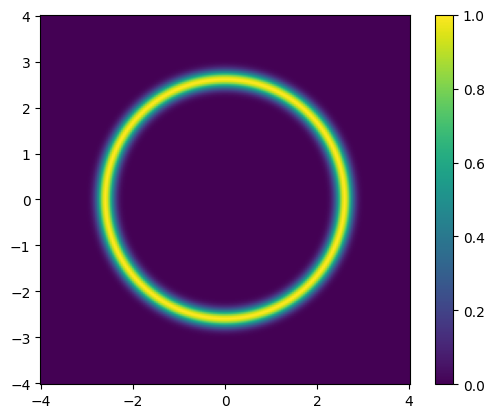

In [3]:
TA.plot_pdf_2D(target_donut, -4, 4, -4, 4)

## 1. First Example 

The purpose of this example is to see the behaviour of __bad__ and __good__ sampling methods, __complex__ and not so complex computational methods 


- Compute sampling methods with the followig parameters

1. __MH_fixed__ : scale = 0.05, Ns = 10000, Nb = 0
2. __MH_adapted__:  scale = 0.05, Ns = 8500, Nb = 1500
3.  __ULA__: scale = 0.065, Ns = 10000, Nb = 0
4.  __MALA__: scale = 0.065, Ns = 10000, Nb = 5000
5. __NUTS__: scale = 0.05, Ns = 1000, Nb = 100


In [3]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [4]:
df = TA.create_comparison(
    target_donut, 
    [0.05], 
    [10000], 
    [0], 
    x0=y ,
    seed=12, 
    chains = 2,
    selected_criteria=["ESS", "AR", "LogPDF", "Gradient", "Rhat"],
    selected_methods=["MH_fixed"]
)


Sample 10000 / 10000

Average acceptance rate: 0.877 

Sample 10000 / 10000

Average acceptance rate: 0.877 



- Print the samples diagnostics in a tabular format

In [5]:
TA.print_table(df)

+----------+---------+----------+-------+---------+---------+-------+--------+----------+----------+----------+
|  Method  | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |   AR  | LogPDF | Gradient | Rhat(v0) | Rhat(v1) |
+----------+---------+----------+-------+---------+---------+-------+--------+----------+----------+----------+
| MH_fixed |  10000  |    0     |  0.05 |  1.875  |   2.44  | 0.877 | 10000  |    0     |  1.356   |  1.243   |
+----------+---------+----------+-------+---------+---------+-------+--------+----------+----------+----------+


In [6]:
df , (fig, axs) = TA.create_comparison(target_donut, [0.05, 0.05, 0.065, 0.065, 0.05 ], [10000, 8500, 10000, 10000, 1000],[0, 1500, 0, 5000, 100], selected_criteria=["LogPDF"])

Sample 10000 / 10000

Average acceptance rate: 0.8755 

Sample 10000 / 10000

Average acceptance rate: 0.5038823529411764 MCMC scale: 0.39102792364656824 

Sample 10000 / 10000
Sample 15000 / 15000
Sample 484 / 1100

_Observations_
- The MH_fixed is a bad sampling method in this: ESS is low and the AR is too high (the samples are somewhat corrrelated)
- the MH_adapted is still not great, however, one can see the improvement in the ESS value, also AR is lower, which might be due to adapting the scale to a higher one. 
- Neither of these use gradient, thus the number of computed Gradients is 0
- the ULA method shows a good ESS and an accceptence rate of 1.0, this is expected since ULA does not have the choice of declining a step
- MALA improves upon ULA with a more balanced ESS but at the cost of increased computational complexity. 
- NUTS: significantly outperforms other methods; however, it can clearly be seen that it has the by far the highest computational costs out of all methods, even though it has significantly less samples

- Now we will take a look at the samples of each method plotted onto the "donut" distribution graphs

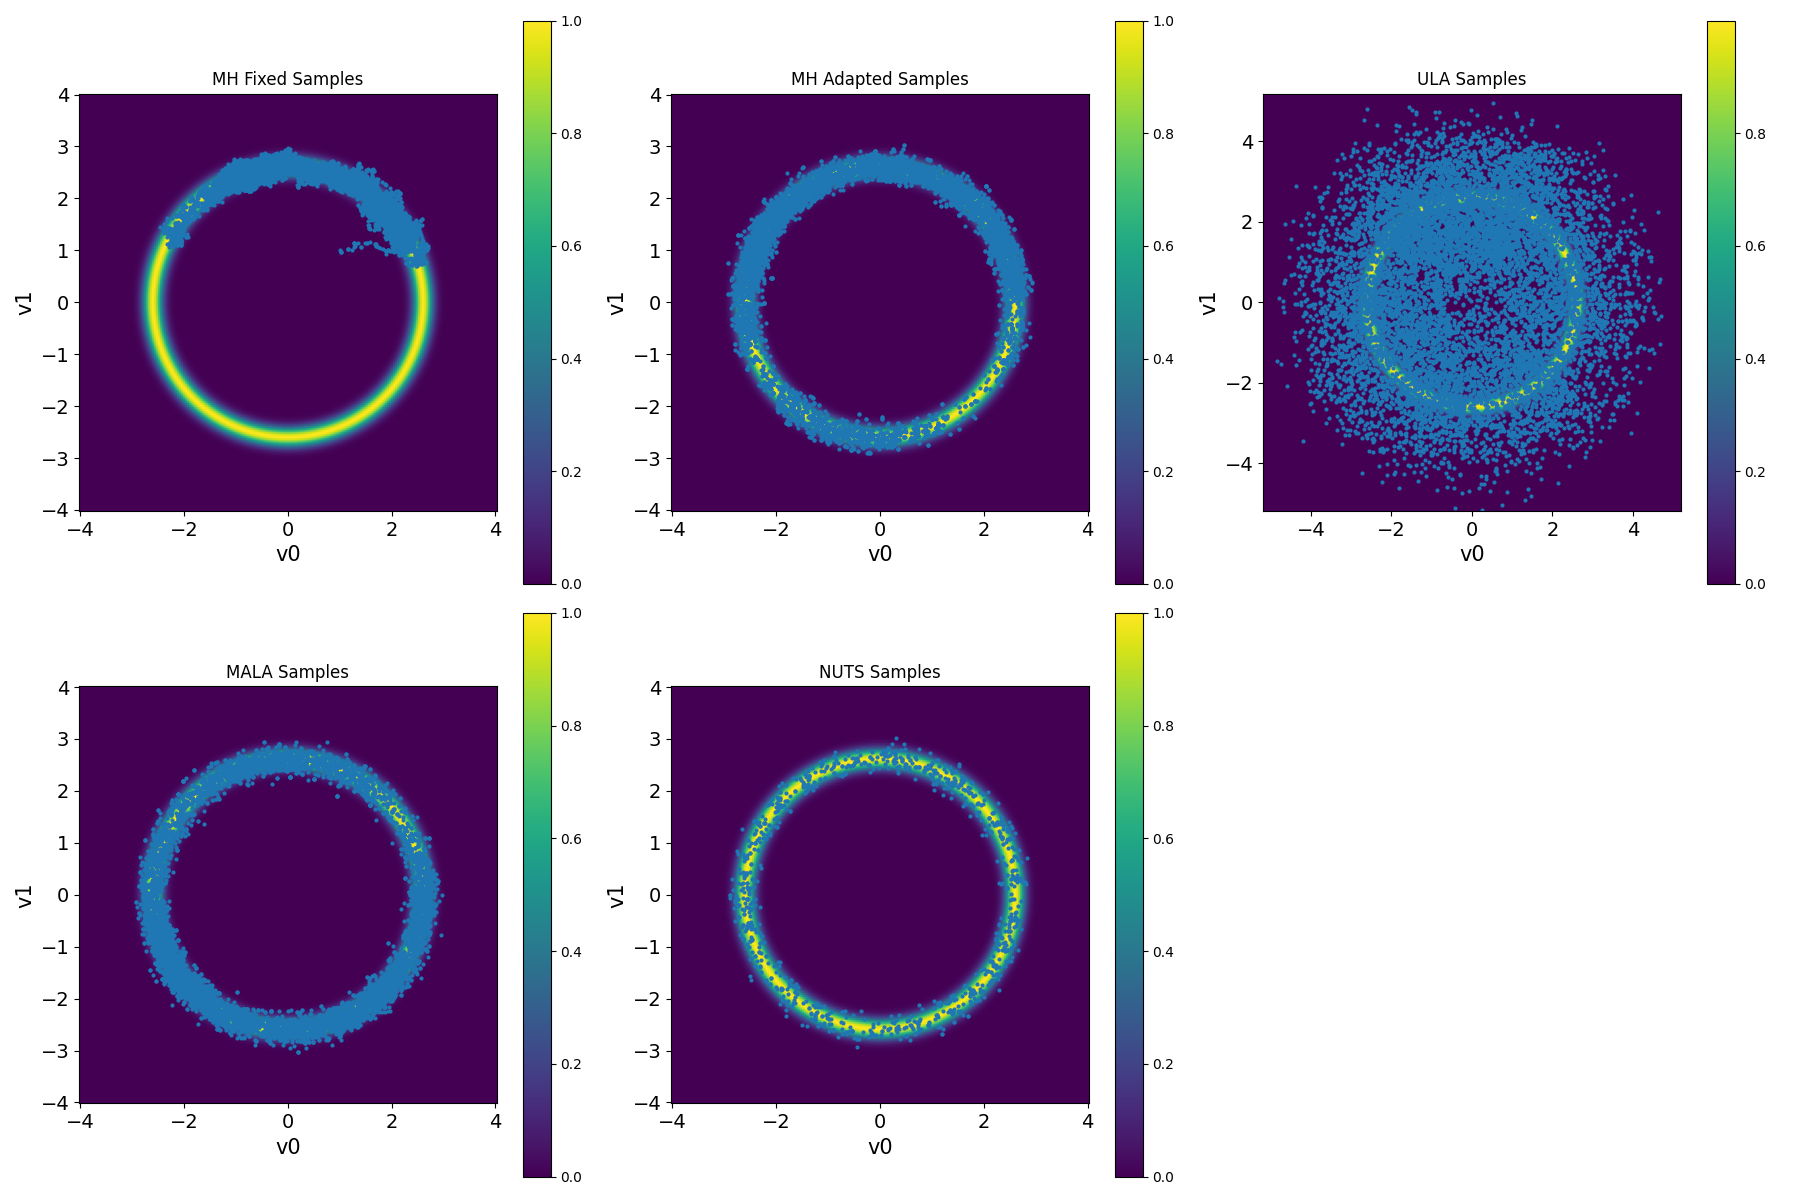

In [6]:
TA.show_plot(fig)

_Observations_
- as expected the MH_fixed does not stray far away from the initial point 
- MH_adapted scale chaging can be seen in the graph, as there are more points in certain areas compared to others
- ULA plot shows clearly the lack of rejection in the algorithm 
- both MALA and NUTS provide quite an accurate sample representation 

## 2. Second example
In this example, we sample x0 from an initial dstribution, and we use the same number of samples, burnins and the same scale for each method: 
- scale = 0.05
- Ns = 8500
- Nb = 1500

- Compute sampling methods

In [7]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [8]:
df, (fig, axs) = TA.create_comparison(target_donut, 0.05, 8500, 1500, x0 = y, seed = 12,chains=2)

Sample 10000 / 10000

Average acceptance rate: 0.8771764705882353 

Sample 10000 / 10000

Average acceptance rate: 0.4944705882352941 MCMC scale: 0.3834746661116212 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.8771764705882353 

Sample 10000 / 10000

Average acceptance rate: 0.4944705882352941 MCMC scale: 0.3834746661116212 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000


- Print table

In [9]:
TA.print_table(df)

+------------+---------+----------+-------+----------+----------+-------+----------+----------+--------+----------+
|   Method   | Samples | Burn-ins | Scale | ESS(v0)  | ESS(v1)  |   AR  | Rhat(v0) | Rhat(v1) | LogPDF | Gradient |
+------------+---------+----------+-------+----------+----------+-------+----------+----------+--------+----------+
|  MH_fixed  |   8500  |   1500   |  0.05 |   4.64   |  5.652   | 0.877 |  1.101   |  1.085   | 10000  |    0     |
| MH_adapted |   8500  |   1500   |  0.05 |  22.959  |  16.962  | 0.494 |   1.01   |  1.033   | 10000  |    0     |
|    ULA     |   8500  |   1500   |  0.05 |  21.207  |  21.759  |  1.0  |  1.012   |  1.001   | 10000  |  10000   |
|    MALA    |   8500  |   1500   |  0.05 |  14.541  |  17.377  | 0.629 |   1.06   |  1.018   | 10000  |  10000   |
|    NUTS    |   8500  |   1500   |  0.05 | 2914.429 | 3255.493 | 0.784 |   1.0    |   1.0    | 290577 |  290577  |
+------------+---------+----------+-------+----------+----------+-------

_Observations_
- It can be seen base on the parameters ESS and AR that MH preformes quite poorly, though adaptive sampling performs better, it is still not ideal. On the other hand, a pro of MH is the low computational costs 
- ULA has acceptence rate AR=1, as expected, and it performs well, with ESSparameters not too high but higher than MH, also R_hat is close to 1, meaing that it converges well enough
- MALA performs decently, but once again it can be seen that NUTS outperforms the other algotithms by far, based on the Rhat and ESS values; however the costs are also way higher compared to the other algorithms. 

- Now we will take a look at the samples of each method plotted onto the "donut" distribution graphs

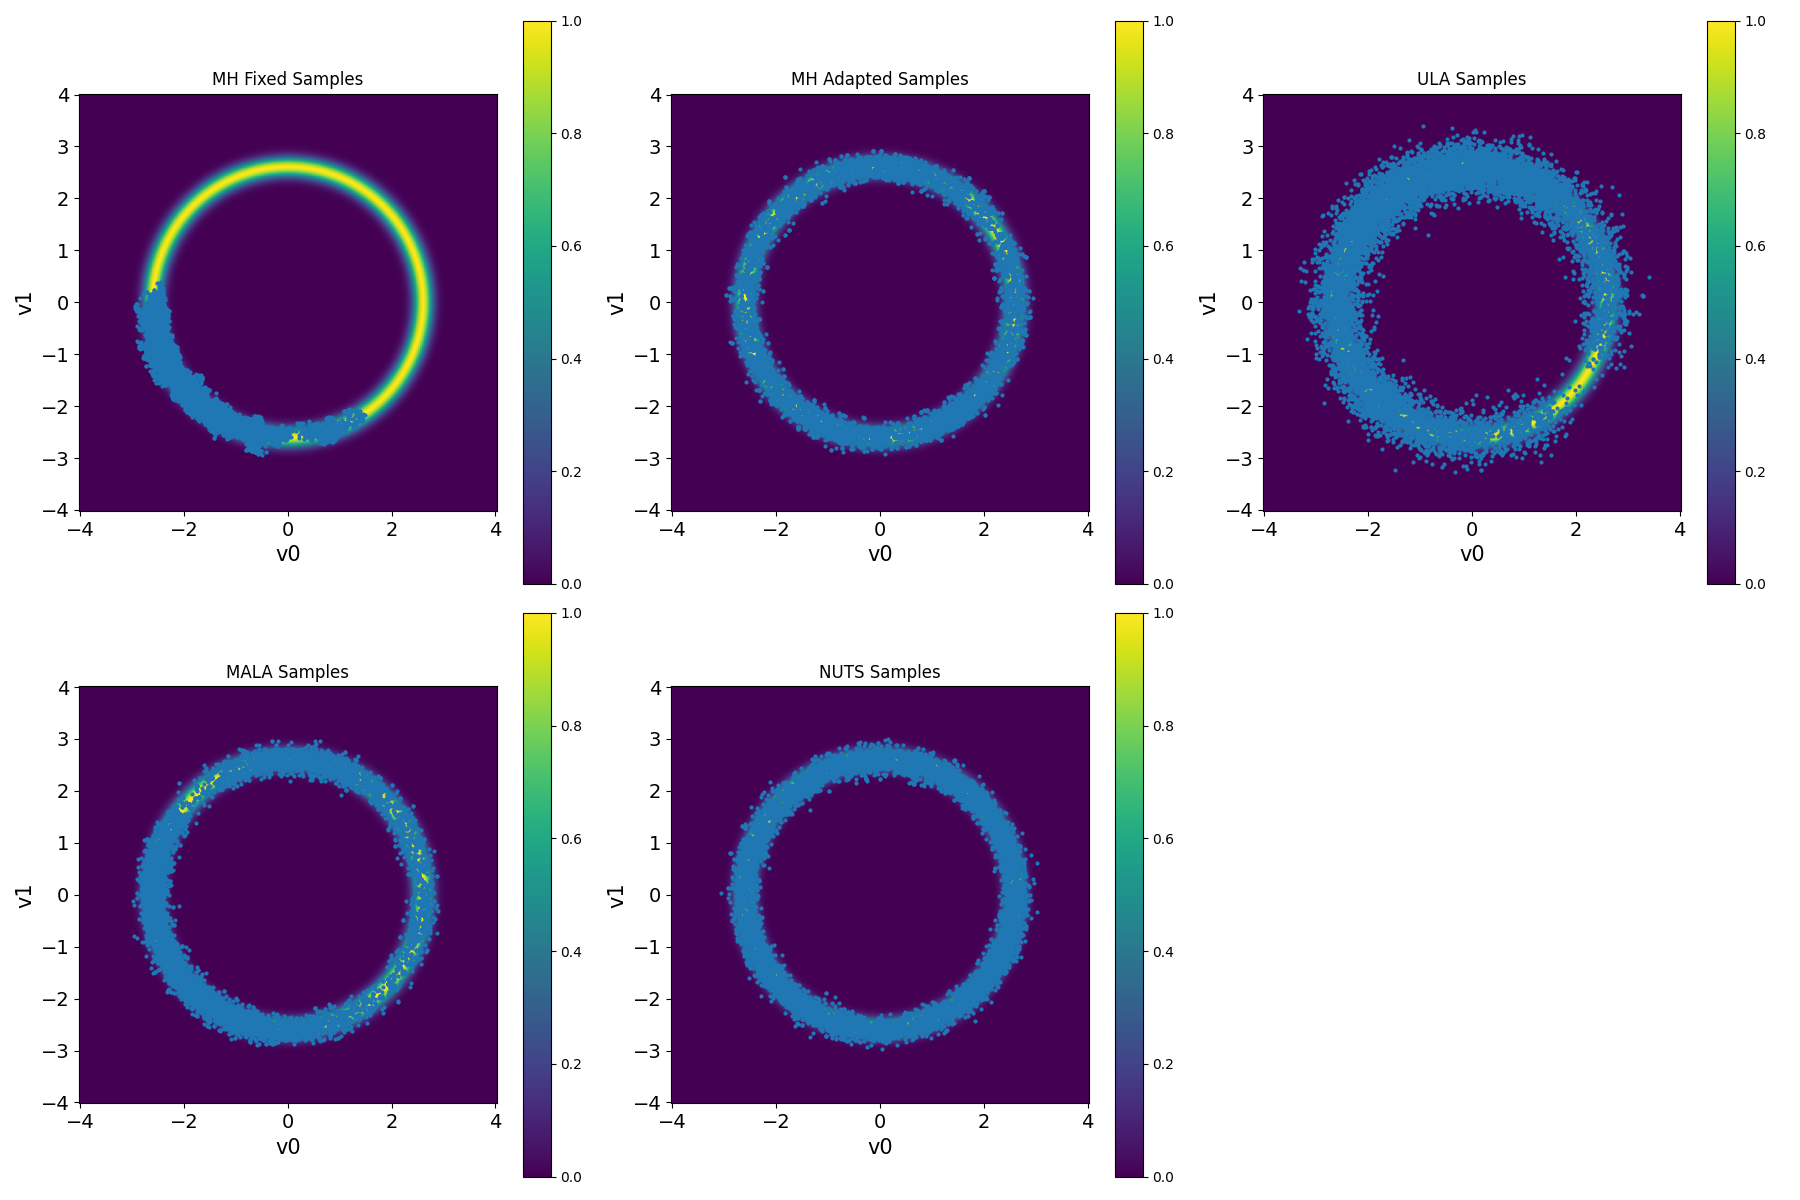

In [10]:
TA.show_plot(fig)

_Observations_
- as expected the MH_fixed does not stray far away from the initial point 
- MH_adapted scale chaging can be seen in the graph, as there are more points in certain areas compared to others
- both MALA and NUTS provide quite an accurate sample representation 

- compared to the previous graphss,it can be seen that setting a relatively high number of burn-ins will lead to better results 